In [1]:
library(keras)
library(dplyr) 
use_condaenv('r-tensorflow')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



The function get.scale returns a list with two parameters : first the mean, second the std. If the input is already centered (it has an attribute center which is taken up by attr), we extract the mean. If it's not, we put the mean by default at 0. If the input is already scale (it has an attribute scale), we extract the std, if it's not we put the std by default at 1.
The function scale.as enables to scale a data set X2 the same way X1 was scaled

In [2]:
get.scale <- function(scaled) {
  if ("scaled:center" %in% names(attributes(scaled))) {
      center <- attr(scaled, "scaled:center")
  } else {
      center <- rep(0, ncol(scaled))
  }
  if ("scaled:scale" %in% names(attributes(scaled))) {
      list(center, attr(scaled, "scaled:scale"))
  } else {
      list(center, rep(1., length(center)))
  }
}
scale.as.x <- function(x, scaled) {
  s <- get.scale(scaled)
  centered <- sweep(x, 2, s[[1]])
  sweep(centered, 2, s[[2]], FUN = "/")
}

scale.as.y <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}

unscale.y <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

In [3]:
train.data <- read.csv(file.path("..", "data", "training_data.csv"))
test.data <- read.csv(file.path("..", "data", "test_data.csv"))


In [21]:
install.packages('kerastuneR')

also installing the dependencies ‘crosstalk’, ‘countrycode’, ‘plotly’, ‘RJSONIO’, ‘rjson’, ‘tidyjson’, ‘echarts4r’, ‘magick’

Warning message in install.packages("kerastuneR"):
“installation of package ‘magick’ had non-zero exit status”Warning message in install.packages("kerastuneR"):
“installation of package ‘kerastuneR’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [96]:
#searching for input variables with zero variance (without the varible Intensity)
x = train.data[, -c(2,3)]
y = train.data$VALENCE.PLEASANTNESS
x$Intensity <- as.numeric(train.data$Intensity)
idx.zero.var <- apply(x, 2, var) == 0
#x is the whole training data (only predictors)
x <- x[,!idx.zero.var]


test.x <- test.data[,-c(1,2)]

test.x$Intensity <- as.numeric(test.data$Intensity)
test.x <- test.x[,!idx.zero.var]

full.data = data.frame(x,y)

In [97]:
#Split the data between a training and a test set
set.seed(100)
len <- length(x[,1])
idx.train <- sample(1:len, 2/3*len)

train.x <- x[idx.train,]
train.y <- y[idx.train]
validation.x <- x[-idx.train,]
validation.y <- y[-idx.train]


train.x.prep <- scale(train.x, center = T, scale = T)
train.y.prep <- scale(train.y, center = T, scale = T)

validation.x.scaled = scale.as.x(validation.x,train.x.prep)
validation.y.scaled = scale.as.y(validation.y,train.y.prep)
#We have 472 rows in the training set, and 472 for the test set
#Training data is scaled 


test.x.scaled = scale.as.x(test.x,train.x.prep)


In [89]:
#FLAGS <- flags(
#  flag_numeric('dropout_1', 0.04, 'First dropout'),
#  flag_numeric('dropout_2', 0.3, 'Second dropout'),
#  flag_integer('dense_units', 100, 'Units in dense layer')
#)


In [82]:
set.seed(100)
nn <- keras_model_sequential()
nn <- nn %>%
      layer_dense(units = 50, activation = 'relu', input_shape = c(dim(train.x)[2]),
                  kernel_regularizer = regularizer_l2(l = 0.01)) %>%
      layer_dropout(rate= 0.3)%>%
      layer_dense(units = 50, activation = 'relu') %>%
      layer_dropout(rate = 0.25)%>%
      layer_dense(units = 1, activation = 'linear')


In [83]:
nn %>% compile(optimizer = "adam", loss = "mean_squared_error", metrics = list("mean_absolute_error"))

In [84]:
set.seed(100)
batch_size = 200
epochs = 100
history <- nn %>% fit(as.matrix(train.x.prep),
                      as.matrix(train.y.prep),
                      verbose = 1,
                      batch_size = batch_size,
                      validation_data = list(as.matrix(validation.x.scaled),as.matrix(validation.y.scaled)),
                      epochs = epochs)


`geom_smooth()` using formula 'y ~ x'


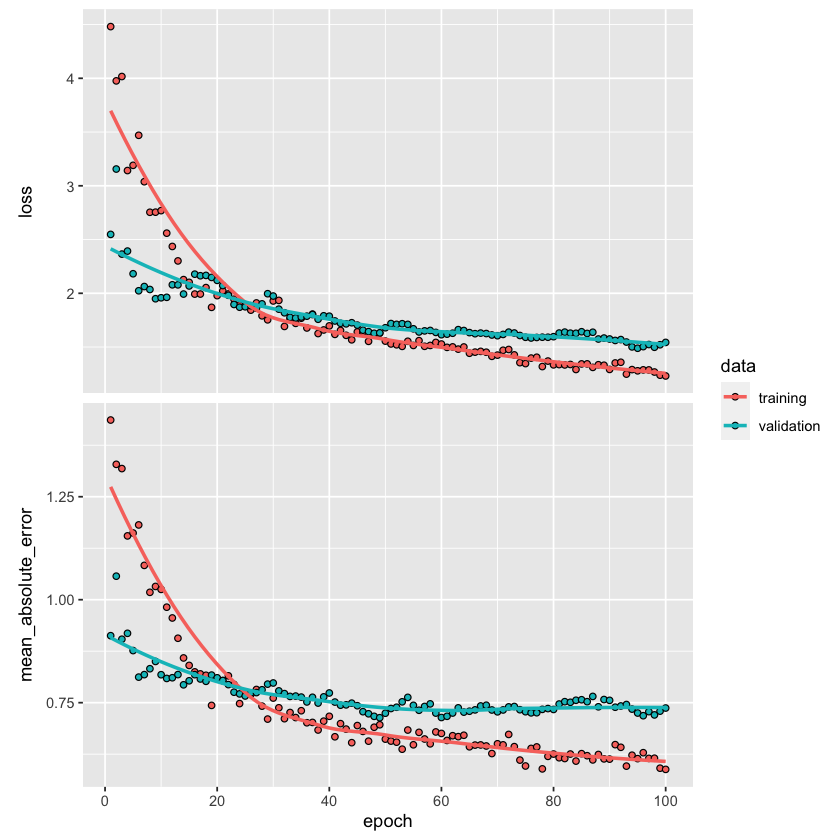

In [85]:
plot(history)


In [103]:
nn.pred <- predict(nn, as.matrix(validation.x.scaled))
nn.pred.unscaled = unscale.y(nn.pred, train.y.prep)

sqrt(mean((nn.pred.unscaled - validation.y)^2))

[1] 22.08989

In [ ]:
prediction <- predict(nn, as.matrix(test.x.scaled)
prediction